In [1]:
import pandas as pd
import altair as alt
import geopandas as gpd
import json
from shapely.geometry import Point, Polygon
import shapely.wkt
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import numpy as np

app = dash.Dash(__name__, assets_folder='assets')
app.config['suppress_callback_exceptions'] = True
server = app.server

app.title = 'Vancouver Crime Stats'

df = pd.read_csv('data/crimedata_csv_all_years.csv')
df = df.query('NEIGHBOURHOOD == NEIGHBOURHOOD & NEIGHBOURHOOD != "Musqueam" & NEIGHBOURHOOD != "Stanley Park"')
df['DATE'] = pd.to_datetime({'year':df['YEAR'], 'month':df['MONTH'], 'day':df['DAY'], 'hour':df['HOUR']})
df['DAY_OF_WEEK_NAME'] = pd.DatetimeIndex(df['DATE']).day_name()
dofw = pd.DataFrame({'DAY_OF_WEEK_NAME': ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], 'DAY_OF_WEEK': [1,2,3,4,5,6,7]})
df = pd.merge(df, dofw, how="left", on="DAY_OF_WEEK_NAME")

In [2]:
df

TYPE  YEAR  MONTH  DAY  \
0                              Break and Enter Commercial  2012     12   14   
1                              Break and Enter Commercial  2019      3    7   
2                              Break and Enter Commercial  2019      8   27   
3                              Break and Enter Commercial  2014      8    8   
4                              Break and Enter Commercial  2005     11   14   
...                                                   ...   ...    ...  ...   
552667  Vehicle Collision or Pedestrian Struck (with I...  2018      8    4   
552668  Vehicle Collision or Pedestrian Struck (with I...  2003      9    1   
552669  Vehicle Collision or Pedestrian Struck (with I...  2005      7   20   
552670  Vehicle Collision or Pedestrian Struck (with I...  2016      6   20   
552671  Vehicle Collision or Pedestrian Struck (with I...  2013     12    3   

        HOUR  MINUTE                 HUNDRED_BLOCK   NEIGHBOURHOOD  \
0          8      52                           NaN        Oakridge   
1          2       6                 10XX SITKA SQ        Fairview   
2          4      12               10XX ALBERNI ST        West End   
3          5      13               10XX ALBERNI ST        West End   
4          3       9               10XX ALBERNI ST        West End   
...      ...     ...                           ...             ...   
552667    16      22     YUKON ST / W BROADWAY AVE  Mount Pleasant   
552668    20      45  YUKON ST / W KING EDWARD AVE      Riley Park   
552669    18      57  YUKON ST / W KING EDWARD AVE      Riley Park   
552670    18      11  YUKON ST / W KING EDWARD AVE      Riley Park   
552671     9      49  YUKON ST / W KING EDWARD AVE      Riley Park   

                    X             Y                DATE DAY_OF_WEEK_NAME  \
0       491285.000000  5.453433e+06 2012-12-14 08:00:00           Friday   
1       490612.964805  5.457110e+06 2019-03-07 02:00:00         Thursday   
2       491007.779775  5.459174e+06 2019-08-27 04:00:00          Tuesday   
3       491015.943352  5.459166e+06 2014-08-08 05:00:00           Friday   
4       491021.385727  5.459161e+06 2005-11-14 03:00:00           Monday   
...               ...           ...                 ...              ...   
552667  491786.000000  5.456719e+06 2018-08-04 16:00:00         Saturday   
552668  491786.000000  5.455143e+06 2003-09-01 20:00:00           Monday   
552669  491786.000000  5.455143e+06 2005-07-20 18:00:00        Wednesday   
552670  491786.000000  5.455143e+06 2016-06-20 18:00:00           Monday   
552671  491835.000000  5.455126e+06 2013-12-03 09:00:00          Tuesday   

        DAY_OF_WEEK  
0                 5  
1                 4  
2                 2  
3                 5  
4                 1  
...             ...  
552667            6  
552668            1  
552669            3  
552670            1  
552671            2  

[552672 rows x 13 columns]

In [3]:
alt.__version__

'3.2.0'

In [35]:
def get_geopandas_df(path):
    """
    Create a geopandas dataframe from the geeojson at the specified filepath
    """
    with open(path) as json_data:
        open_json = json.load(json_data)
    gdf = gpd.GeoDataFrame.from_features(open_json)
    return gdf

geojson_filepath = 'data/our_geojson.geojson'
gdf = get_geopandas_df(geojson_filepath)
gdf = gdf.rename(columns = {'Name': 'NEIGHBOURHOOD'}).drop(columns = 'description')

crime_cnt_pre = (df.groupby(['YEAR', 'NEIGHBOURHOOD', 'TYPE'])[['MINUTE']]
                 .count()
                 .rename(columns = {'MINUTE': 'COUNT'})
                 .reset_index()
                )

In [36]:
crime_cnt_pre

YEAR    NEIGHBOURHOOD  \
0     2003    Arbutus Ridge   
1     2003    Arbutus Ridge   
2     2003    Arbutus Ridge   
3     2003    Arbutus Ridge   
4     2003    Arbutus Ridge   
...    ...              ...   
3158  2019  West Point Grey   
3159  2019  West Point Grey   
3160  2019  West Point Grey   
3161  2019  West Point Grey   
3162  2019  West Point Grey   

                                                   TYPE  COUNT  
0                            Break and Enter Commercial     34  
1                     Break and Enter Residential/Other    141  
2                                              Mischief     95  
3                                           Other Theft     35  
4                                    Theft from Vehicle    177  
...                                                 ...    ...  
3158                                 Theft from Vehicle    154  
3159                                   Theft of Bicycle     27  
3160                                   Theft of Vehicle     14  
3161  Vehicle Collision or Pedestrian Struck (with F...      1  
3162  Vehicle Collision or Pedestrian Struck (with I...     10  

[3163 rows x 4 columns]

In [34]:
crime_cnt = crime_cnt_pre.query('2010 <= YEAR & YEAR <= 2018').reset_index()
crime_cnt

YEAR    NEIGHBOURHOOD  \
0     2010    Arbutus Ridge   
1     2010    Arbutus Ridge   
2     2010    Arbutus Ridge   
3     2010    Arbutus Ridge   
4     2010    Arbutus Ridge   
...    ...              ...   
1657  2018  West Point Grey   
1658  2018  West Point Grey   
1659  2018  West Point Grey   
1660  2018  West Point Grey   
1661  2018  West Point Grey   

                                                   TYPE  COUNT  
0                            Break and Enter Commercial     17  
1                     Break and Enter Residential/Other    122  
2                                              Mischief     46  
3                                           Other Theft     25  
4                                    Theft from Vehicle     71  
...                                                 ...    ...  
1657                                        Other Theft     11  
1658                                 Theft from Vehicle    157  
1659                                   Theft of Bicycle     32  
1660                                   Theft of Vehicle     11  
1661  Vehicle Collision or Pedestrian Struck (with I...     22  

[1662 rows x 4 columns]

In [32]:
crime_cnt.groupby('NEIGHBOURHOOD').sum()

COUNT
NEIGHBOURHOOD                   
Arbutus Ridge               3155
Central Business District  68811
Dunbar-Southlands           4274
Fairview                   16132
Grandview-Woodland         14585
Hastings-Sunrise            9630
Kensington-Cedar Cottage   13187
Kerrisdale                  3912
Killarney                   5105
Kitsilano                  13636
Marpole                     6808
Mount Pleasant             18803
Oakridge                    4726
Renfrew-Collingwood        14799
Riley Park                  7166
Shaughnessy                 3254
South Cambie                3004
Strathcona                 13098
Sunset                      8140
Victoria-Fraserview         5449
West End                   21947
West Point Grey             3138

In [5]:
def plot_choropleth2(year_init = 2010, year_end = 2018, crime_type = 'all', crime_threshold = 1):
    """
    Create choropleth of crime data across neighbourhoods in Vancouver

    Parameters
    ----------
    year_init : int (default 2010)
        start year of data set
    year_end : int (default 2018)
        ending year of data set
    crime_type : str (default 'ALL')
        crime type to examine
    crime_threshold : float
        maximum value of choropleth color scale

    Returns
    -------
    altair.Chart object
        altair choropleth chart with filtered crime data
    """
    crime_cnt = (crime_cnt_pre.query('@year_init <= YEAR & YEAR <= @year_end')
                .reset_index())

    if(crime_type.lower() == 'all'):
        crime_type = 'All Crimes'
        crime_cnt = crime_cnt.groupby('NEIGHBOURHOOD')[['COUNT']].sum().reset_index()
    else:
        crime_cnt = crime_cnt.query('TYPE == @crime_type').groupby('NEIGHBOURHOOD')[['COUNT']].sum().reset_index()

    crime_cnt['MINMAX'] = (crime_cnt['COUNT'] - crime_cnt['COUNT'].min()) / (crime_cnt['COUNT'].max() - crime_cnt['COUNT'].min())
    crime_cnt['MINMAX'] = round(crime_cnt['MINMAX'], 3)
    crime_geo_cnt = gdf.merge(crime_cnt, on = 'NEIGHBOURHOOD')

    alt_json = json.loads(crime_geo_cnt.to_json())
    alt_base = alt.Data(values = alt_json['features'])

    base_map = alt.Chart(alt_base, 
                        title = f"Crime Type = {crime_type}").mark_geoshape(
            stroke='white',
            strokeWidth=1
        ).encode(
            tooltip = [alt.Tooltip('properties.NEIGHBOURHOOD:N', title =  'Neighbourhood'), 
                    alt.Tooltip('properties.COUNT:Q', title = 'Count'), 
                    alt.Tooltip('properties.MINMAX:Q', title =  'Ratio')]
        ).properties(
            width=1000,
            height=600
        )

    choro = alt.Chart(alt_base).mark_geoshape(
        fill = 'lightgray', 
        stroke = 'white'
    ).encode(
        alt.Color('properties.MINMAX:Q', 
        legend = alt.Legend(title = 'Crime Index'), 
        scale=alt.Scale(domain = (0.0, crime_threshold),
                        range = ('#CAFFA8', '#DF3F12', '#000000')
                        )
        )
    )

    return (choro + base_map).configure_title(fontSize=15).properties(width = 700, height = 400)

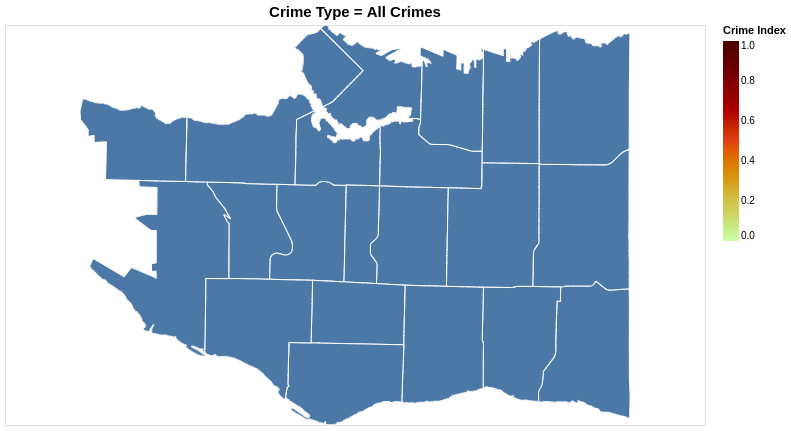

In [10]:
plot_choropleth2()

In [8]:
def plot_choropleth(year_init = 2010, year_end = 2018, crime_type = 'all', crime_threshold = 1):
    """
    Create choropleth of crime data across neighbourhoods in Vancouver

    Parameters
    ----------
    year_init : int (default 2010)
        start year of data set
    year_end : int (default 2018)
        ending year of data set
    crime_type : str (default 'ALL')
        crime type to examine
    crime_threshold : float
        maximum value of choropleth color scale

    Returns
    -------
    altair.Chart object
        altair choropleth chart with filtered crime data
    """
    crime_cnt = (df.query('@year_init <= YEAR & YEAR <= @year_end').groupby(['NEIGHBOURHOOD', 'TYPE'])[['MINUTE']]
                .count().rename(columns = {'MINUTE': 'COUNT'})
                .reset_index())

    if(crime_type.lower() == 'all'):
        crime_type = 'All Crimes'
        crime_cnt = crime_cnt.groupby('NEIGHBOURHOOD')[['COUNT']].sum().reset_index()
    else:
        crime_cnt = crime_cnt.query('TYPE == @crime_type').groupby('NEIGHBOURHOOD')[['COUNT']].sum().reset_index()

    crime_cnt['MINMAX'] = (crime_cnt['COUNT'] - crime_cnt['COUNT'].min()) / (crime_cnt['COUNT'].max() - crime_cnt['COUNT'].min())
    crime_cnt['MINMAX'] = round(crime_cnt['MINMAX'], 3)
    crime_geo_cnt = gdf.merge(crime_cnt, on = 'NEIGHBOURHOOD')

    alt_json = json.loads(crime_geo_cnt.to_json())
    alt_base = alt.Data(values = alt_json['features'])

    base_map = alt.Chart(alt_base, 
                        title = f"Crime Type = {crime_type}").mark_geoshape(
            stroke='white',
            strokeWidth=1
        ).encode(
            tooltip = [alt.Tooltip('properties.NEIGHBOURHOOD:N', title =  'Neighbourhood'), 
                    alt.Tooltip('properties.COUNT:Q', title = 'Count'), 
                    alt.Tooltip('properties.MINMAX:Q', title =  'Ratio')]
        ).properties(
            width=1000,
            height=600
        )

    choro = alt.Chart(alt_base).mark_geoshape(
        fill = 'lightgray', 
        stroke = 'white'
    ).encode(
        alt.Color('properties.MINMAX:Q', 
                legend = alt.Legend(title = 'Crime Index'), 
                scale=alt.Scale(domain = (0.0, crime_threshold),
                                range = ('#CAFFA8', '#DF3F12', '#000000')
                                )
                )
    )

    return (choro + base_map).configure_title(fontSize=15).properties(width = 700, height = 400)

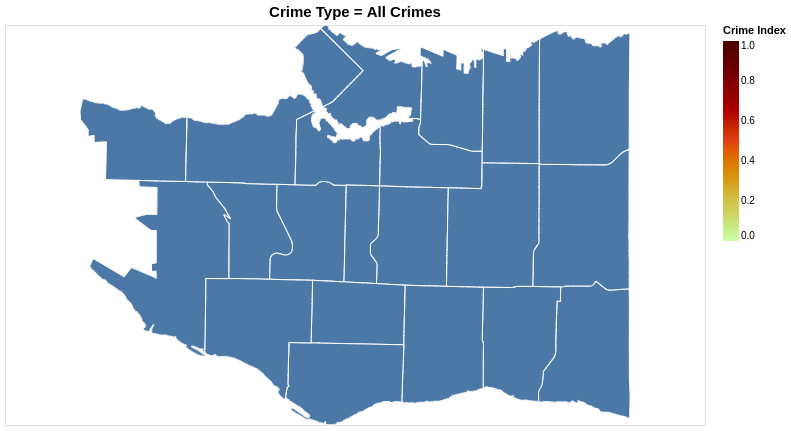

In [11]:
plot_choropleth()

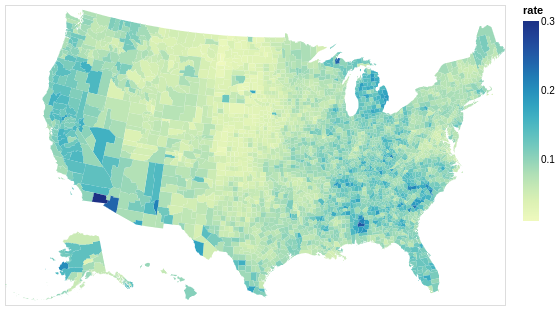

In [24]:
import altair as alt
from vega_datasets import data

counties = alt.topo_feature(data.us_10m.url, 'counties')
source = data.unemployment.url

alt.Chart(counties).mark_geoshape().encode(
    color='rate:Q',
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', ['rate'])
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300
)

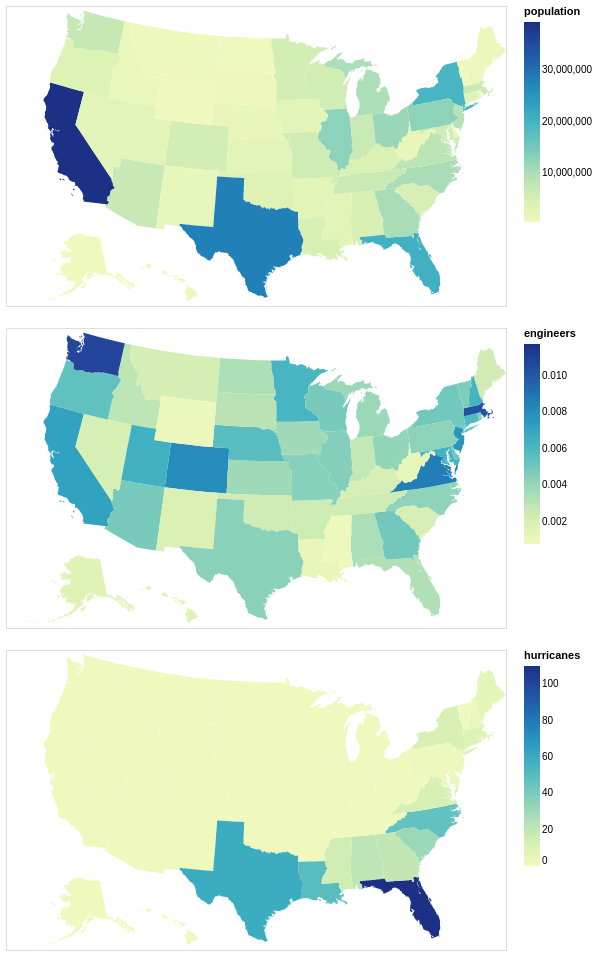

In [25]:
import altair as alt
from vega_datasets import data

states = alt.topo_feature(data.us_10m.url, 'states')
source = data.population_engineers_hurricanes.url
variable_list = ['population', 'engineers', 'hurricanes']

alt.Chart(states).mark_geoshape().encode(
    alt.Color(alt.repeat('row'), type='quantitative')
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', variable_list)
).properties(
    width=500,
    height=300
).project(
    type='albersUsa'
).repeat(
    row=variable_list
).resolve_scale(
    color='independent'
)